[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-1/router.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239412-lesson-5-router)

英文原版：https://github.com/langchain-ai/langchain-academy/tree/main

译者：Bryce Wang, brycewang2018@gmail.com

# 1.3 Router

## 回顾

我们构建了一个使用 `messages` 作为状态的图，并绑定了工具的聊天模型。

我们发现该图可以：

返回一个工具调用
返回一个自然语言响应

## Goals

我们可以将其视为一个路由器，其中聊天模型根据用户输入在直接响应和工具调用之间进行路由。

这是一个代理的简单示例，其中 LLM 控制流程的方向，要么调用工具，要么直接响应。

![Screenshot 2024-08-21 at 9.24.09 AM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbac6543c3d4df239a4ed1_router1.png)


让我们扩展这个图，使其可以处理这两种输出！

为此，我们可以使用两个想法：

- 添加一个节点，用于调用我们的工具。

- 添加一个条件边，根据聊天模型的输出，将流程路由到`工具调用`节点，或者如果未执行工具调用，则直接`结束`。

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core langgraph

In [1]:
## 设置 API key 环境变量
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

In [2]:
## 定义并绑定工具 multiply 函数
from langchain_openai import ChatOpenAI

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools([multiply])

我们使用 内置的 [`ToolNode`](https://langchain-ai.github.io/langgraph/reference/prebuilt/?h=tools+condition#toolnode)，只需传递我们的工具列表即可初始化它。

我们使用 内置的 [`tools_condition`](https://langchain-ai.github.io/langgraph/reference/prebuilt/?h=tools+condition#tools_condition) 作为我们的条件边。

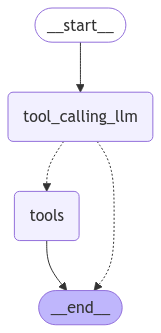

In [3]:
## 创建图
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm) ## 工具调用节点
builder.add_node("tools", ToolNode([multiply])) # 工具节点
builder.add_edge(START, "tool_calling_llm") # 开始节点 --> 工具调用节点
builder.add_conditional_edges( # 工具调用节点 -条件边-> 工具节点
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

我们比较下上次课创建的那个不能实现足够输出的图。因为它缺少了一个可以执行的工具节点：

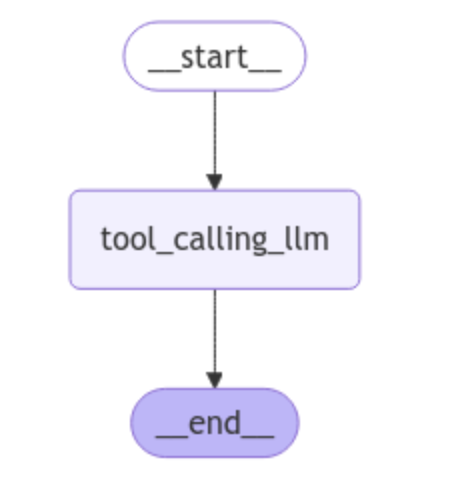

In [4]:
## 运行图 
from langchain_core.messages import HumanMessage
messages = [HumanMessage(content="Hello world.")]
messages = graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello world.
================================== Ai Message ==================================

Hello! How can I assist you today?


In [5]:
## 提出一个乘法相关的题目
messages = [HumanMessage(content="What is 2 multiply by 3?.")]
messages = graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is 2 multiply by 3?.
================================== Ai Message ==================================
Tool Calls:
  multiply (call_YH8uhkOOokgDqHr8PGY9I0rl)
 Call ID: call_YH8uhkOOokgDqHr8PGY9I0rl
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6


现在，我们可以看到图形运行了工具！

它以 `ToolMessage` 的形式响应。

In [ ]:
## END